https://www.tensorflow.org/tutorials/keras/text_classification

Sentiment Analysis
- This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.
- text_dataset_from_directory - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory

In [1]:
# !pip install tensorflow --upgrade

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.3.0


In [3]:
# https://ai.stanford.edu/~amaas/data/sentiment/
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir='.', cache_subdir='')
print(dataset)
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

.\aclImdb_v1.tar.gz


In [4]:
print(os.listdir(dataset_dir), "##")
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train'] ##
['labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


In [5]:
# aclImdb/train/pos 
# aclImdb/train/neg

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [13]:
batch_size = 32
seed = 42

# TRAIN

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])
    
# check class names property of dataset
print("")
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

# VALIDATION
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

# TEST
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films w

In [14]:
# remove <br /> 
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

max_features = 10000
sequence_length = 250

# output_mode: int - create unqiue integer indices for each token
# sequence_length: will cause the layer to pad or truncate sequences to exactly sequence_length length
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
# important to call adapt only on TRAIN_SET
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review\n", first_review, "\n")
print("Label\n", raw_train_ds.class_names[first_label], "\n")
print("Vectorized review\n", vectorize_text(first_review, first_label),"\n")

print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Review
 tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string) 

Label
 neg 

Vectorized review
 (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,


In [18]:
# Apply the TextVectorization layer you created earlier to the train, validation, and test dataset.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
# .cache() keeps data in memory after it's loaded off disk. 
#.prefetch() overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 29s 46ms/step - loss: 0.6624 - binary_accuracy: 0.6968 - val_loss: 0.6136 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.5482 - binary_accuracy: 0.8017 - val_loss: 0.4979 - val_binary_accuracy: 0.8232
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4449 - binary_accuracy: 0.8460 - val_loss: 0.4198 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3783 - binary_accuracy: 0.8665 - val_loss: 0.3736 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3352 - binary_accuracy: 0.8789 - val_loss: 0.3445 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3033 - binary_accuracy: 0.8910 - val_loss: 0.3255 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 6s 

In [21]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = history.history
history_dict.keys()

782/782 [==============================] - 46s 59ms/step - loss: 0.3103 - binary_accuracy: 0.8732
Loss:  0.31033018231391907
Accuracy:  0.873199999332428


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

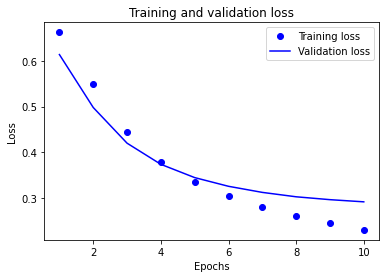

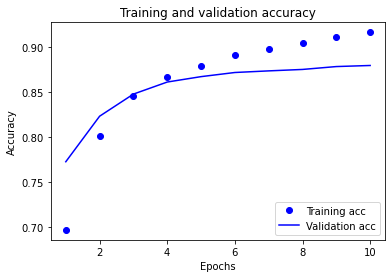

In [22]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [23]:
# Enable the model to work on raw text !

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 23s 30ms/step - loss: 0.3103 - accuracy: 0.87320s - l
0.873199999332428
